In [2]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy.io
import scipy.signal

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
np.random.seed(1337)

In [3]:
train_folder = r"D:\test_development\Battery\data2\Panasonic 18650PF Data prepared\Panasonic_NCR18650PF_Data_Normalized\Train\1/"
val_file = r"D:\test_development\Battery\data2\Panasonic 18650PF Data prepared\Panasonic_NCR18650PF_Data_Normalized\Validation\n10degC_LA92_Pan18650PF.mat"
test_file = r"D:\test_development\Battery\data2\Panasonic 18650PF Data prepared\Panasonic_NCR18650PF_Data_Normalized\Test\Test.mat"
minmax_file = r"D:\test_development\Battery\data2\Panasonic 18650PF Data prepared\Panasonic_NCR18650PF_Data_Normalized\Normalization\MIN_MAX_Normalization.mat"
cols = ['V', 'I', 'T']

In [4]:
minmax = scipy.io.loadmat(minmax_file)
minmax['MAX'][0]

array([ 4.31  , 10.6797, 32.784 ])

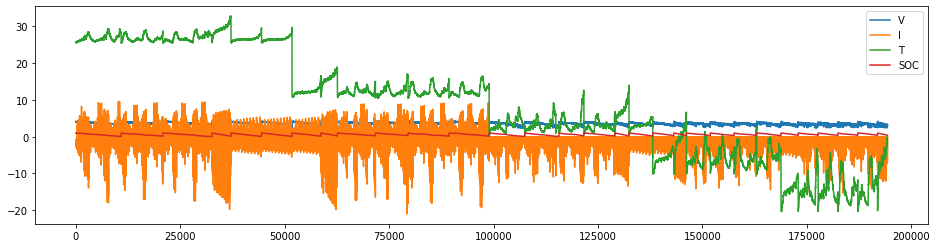

In [5]:
x_train = pd.DataFrame()
y_train = pd.DataFrame()
for file in os.listdir(train_folder):
    mat = scipy.io.loadmat(train_folder + file)
    x_train = pd.concat([x_train, pd.DataFrame(mat['X']).T[[0, 1, 2]]], ignore_index=True)
    y_train = pd.concat([y_train, pd.DataFrame(mat['Y']).T], ignore_index=True)
x_train.columns = cols
y_train.columns = ['SOC']

x_train = x_train * (minmax['MAX'][0] - minmax['MIN'][0]) + minmax['MIN'][0]
pd.concat([x_train, y_train], axis=1).plot(figsize=(16, 4), legend=True)
plt.show()

<ipython-input-47-8a788b2933ac>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  x_other = x_other.resample('S').mean()


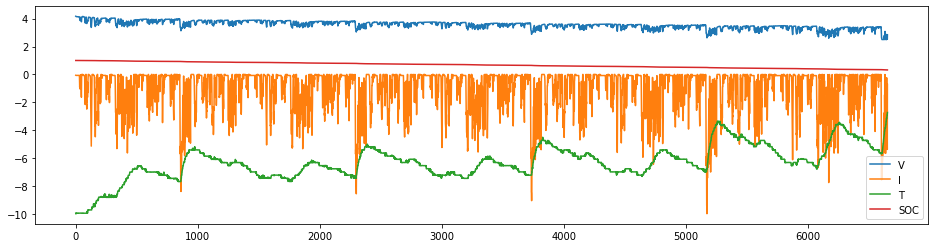

In [47]:
def from_mat(raw_file):
    mat = scipy.io.loadmat(raw_file)
    x_other = pd.DataFrame()
    for i, col in enumerate(mat['meas'][0][0]):
        x_other = pd.concat([x_other, pd.DataFrame(col, columns=[i])], axis=1)
    x_other.drop(columns=[4, 5, 7, 8], inplace=True)
    x_other[0] = x_other[0].str[0]
    x_other.loc[x_other[0].str.len() < 15, 0] = x_other[0] + ' 12:00:00 AM'
    x_other.index = pd.to_datetime(x_other[0], format='%m/%d/%Y %I:%M:%S %p')
    x_other = x_other.resample('S').mean()
    x_other.dropna(how='all', inplace=True)
    return x_other

def from_raw(df):
    x_other = df.copy()

    condition = (x_other.eq(x_other.shift())).any(axis=1)
    duplicates = x_other[condition].groupby((~condition).cumsum())
    x_other.drop(list(duplicates)[0][1].index, inplace=True)
    x_other.drop(list(duplicates)[-1][1].index, inplace=True)
    x_other = x_other.iloc[1:-1]
    x_other = x_other.reset_index(drop=True)
    y_other = pd.DataFrame(x_other.pop(3))

    x_other.columns = cols
    y_other.columns = ['SOC']

    # x_other['V'] = (x_other['V'] - x_other['V'].min()) / (x_other['V'].max() - x_other['V'].min())
    # x_other['I'] = (x_other['I'] - x_other['I'].min()) / (x_other['I'].max() - x_other['I'].min())
    # x_other['T'] = (x_other['T'] - x_other['T'].min()) / (x_other['T'].max() - x_other['T'].min())

    y_other = y_other / 3 % 1

    # butter(x_other)

    return x_other, y_other
    
x_other, y_other = from_raw(from_mat(r"D:\test_development\Battery\data2\Panasonic 18650PF Data original\-10degC\Drive Cycles\06-07-17_08.39 n10degC_LA92_Pan18650PF.mat"))

pd.concat([x_other, y_other], axis=1).plot(figsize=(16, 4), legend=True)
plt.show()

In [48]:
len(x_other)

6653